In [4]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set paths
folder_path = "/content/drive/MyDrive/CSCI3397"
ham10000_path = os.path.join(folder_path, "HAM10000")

# Load metadata
metadata = pd.read_csv(os.path.join(folder_path, "HAM10000_metadata.csv"))

# Update the image_id column to include the full path to the images
metadata["image_id"] = metadata.apply(lambda row: os.path.join(folder_path, "HAM10000_images_part_1", row["image_id"] + ".jpg") if row["image_id"][0] == 'I' else os.path.join(folder_path, "HAM10000_images_part_2", row["image_id"] + ".jpg"), axis=1)


# Split the dataset into training, validation, and test sets
train_df, test_df = train_test_split(metadata, test_size=0.2, random_state=42, stratify=metadata["dx"])
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42, stratify=train_df["dx"])

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

image_size = 299
batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="image_id",
    y_col="dx",
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical",
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col="image_id",
    y_col="dx",
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical",
)
# Load Inception-ResNet-v2 model
base_model = InceptionResNetV2(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(7, activation="softmax", kernel_regularizer=regularizers.l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
num_epochs = 25
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
    epochs=num_epochs,
)

# Save the trained model
model.save("inception_resnet_v2_ham10000.h5")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 3042 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 2967 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


Found 968 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1035 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/25
95/95 [==============================] - 336s 2s/step - loss: 0.9182 - accuracy: 0.7219 - val_loss: 3.9904 - val_accuracy: 0.1844
Epoch 2/25
95/95 [==============================] - 151s 2s/step - loss: 0.7071 - accuracy: 0.7671 - val_loss: 1.3102 - val_accuracy: 0.5844
Epoch 3/25
95/95 [==============================] - 146s 2s/step - loss: 0.6623 - accuracy: 0.7787 - val_loss: 0.9976 - val_accuracy: 0.7125
Epoch 4/25
95/95 [==============================] - 150s 2s/step - loss: 0.6237 - accuracy: 0.7867 - val_loss: 1.9485 - val_accuracy: 0.5458
Epoch 5/25
95/95 [==============================] - 151s 2s/step - loss: 0.5599 - accuracy: 0.8017 - val_loss: 0.6612 - val_accuracy: 0.7823
Epoch 6/25
95/95 [==============================] - 150s 2s/step - loss: 0.5090 - accuracy: 0.8282 - val_loss: 1.1063 - val_accuracy: 0.7594
Epoch 7/25
95/95 [==============================] - 151s 2s/step - loss: 0.4777 - accuracy: 0.8322 - val_loss: 0.7097 - val_accuracy: 0.7760
Epoch 8/25
95

Found 990 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1013 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


31/31 [==============================] - 24s 695ms/step


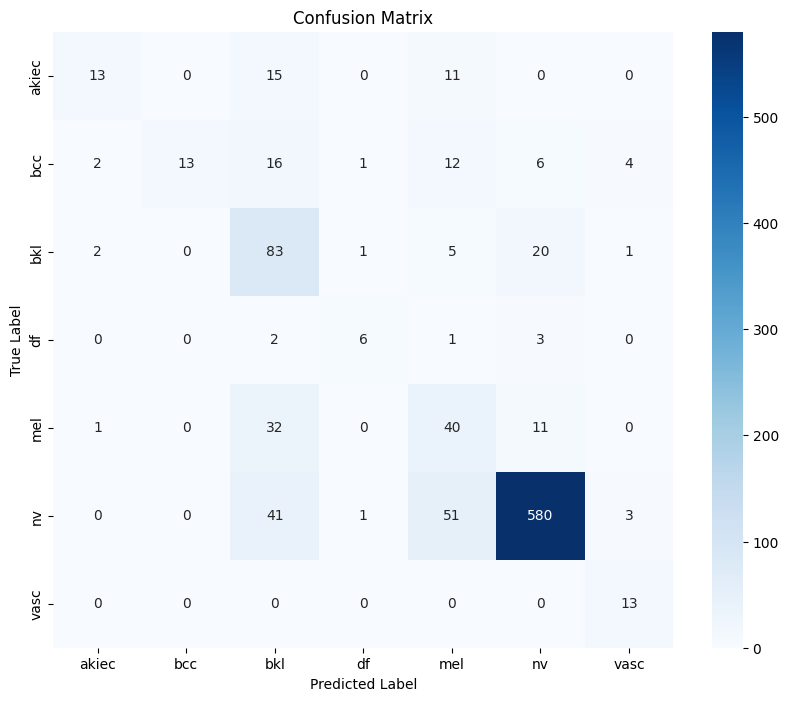

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load the saved model
model = tf.keras.models.load_model("inception_resnet_v2_ham10000.h5")

# Generate predictions for the test set
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col="image_id",
    y_col="dx",
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
actual_labels = test_generator.classes

# Create the confusion matrix
confusion_matrix = confusion_matrix(actual_labels, predicted_labels)

confusion_df = pd.DataFrame(confusion_matrix, index=test_generator.class_indices, columns=test_generator.class_indices)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

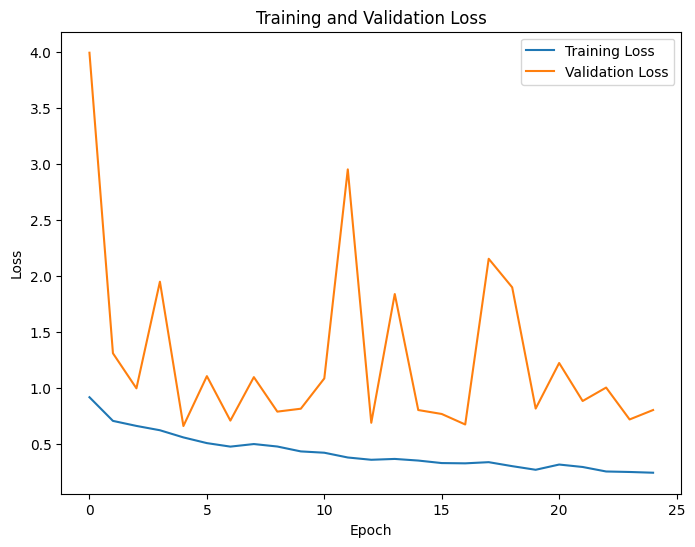

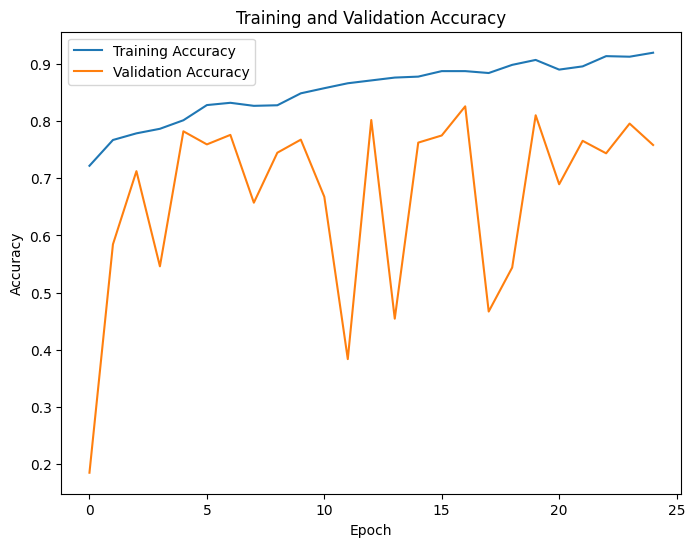

In [22]:
import matplotlib.pyplot as plt

training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()